<a href="https://colab.research.google.com/github/Xirailuyo/PTLearning/blob/master/Notebooks/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

# Load Data

In [0]:
# transforms will be used to define image datasets
data_transforms = {
    'train': transforms.Compose([ # combining function
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Q: why normalize to these values?
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
}

data_dir = 'drive/My Drive/PyTorch/data/hymenoptera_data'
# for data_dir/train/ants, data_dir/train/bees, data_dir/valid/ants,
# data_dir/valid/bees, apply transforms to jpgs data and package them
# into an ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# package ImageFolder into a DataLoader, a deep learning for loop
# that utilizes batches and shuffling
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4)
              for x in ['train', 'val']}
# get lengths and classes of dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# add cuda if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Visualize Images

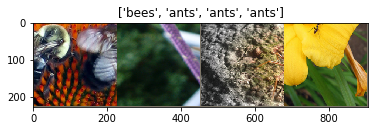

In [6]:
# print function for images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  # numbers are based on dataset?
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std*inp+mean
  inp = np.clip(inp,0,1) # limits inp array
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

# batch of training data
inputs, classes = next(iter(dataloaders['train']))

# grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the Model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  
  # initilize optimization values
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    # print statements
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # training and validation phase for each epoch
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # iterate over data (dataloaders) using phase from for loop
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients of THE OPTIMIZER
        optimizer.zero_grad()

        # Forward Pass
        # track history in train, not validation
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs) # outputs of model given inputs
          _, preds = torch.max(outputs,1) # 2nd var of max is predictions
          loss = criterion(outputs, labels) # calculate loss

          # Backward Pass and Optimization in Training Phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        # statistics
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)
      if phase == 'train':
        scheduler.step()

      # dataset_sizes[phase]: length of phase?
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase=='val' and epoch > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  
  time_elapsed = time.time() - since
  print("Training complete in {:.0f}m {:.0f}s".format(
      time_elapsed//60, time_elapsed%60))
  print("Best val Acc: {:4f}".format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

# Visualize the Model Predictions

In [0]:
def visualize_model(model, num_images=6):
  # initial values
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    # loop through validation with counter i, inputs, and labels
    for i , (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # get outputs, and prediction from outputs
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      # for all inputs, plot
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)


# Finetuning the ConvNet

In [9]:
model_ft = models.resnet18(pretrained=True) # model features from resnet18
num_ftrs = model_ft.fc.in_features # number of input features from model
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) # upload to device

criterion = nn.CrossEntropyLoss()

# optimizer based on parameters, learning rate, and momentum
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# exponentional learning rate scheduler using optimizer
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7,
                                       gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.1MB/s]


# Train and Evaluate

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6255 Acc: 0.7172
val Loss: 0.6542 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.7775 Acc: 0.7541
val Loss: 0.5140 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5188 Acc: 0.7992
val Loss: 0.3038 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.6409 Acc: 0.7377
val Loss: 0.7928 Acc: 0.7124

Epoch 4/24
----------
train Loss: 0.6726 Acc: 0.7705
val Loss: 0.2525 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5893 Acc: 0.7992
val Loss: 0.6270 Acc: 0.8039

Epoch 6/24
----------
train Loss: 0.5322 Acc: 0.8238
val Loss: 0.3241 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3916 Acc: 0.8484
val Loss: 0.2665 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3206 Acc: 0.8566
val Loss: 0.2402 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3731 Acc: 0.8607
val Loss: 0.2400 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2749 Acc: 0.8811
val Loss: 0.2486 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4256 Acc: 0.8320
val Loss: 0.3210 Acc: 0.8693

Ep

In [2]:
visualize_model(model_ft)

NameError: ignored

In [0]:
# freeze all weights except final layer
# requires_grad == False freezes parameters so gradients aren't
# computed in backward() pass
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False # freezing layers

# parameters of new modules have required_grad=True by default
num_ftrs = model_conv.fc.in_features # fully connected input features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# observe only final layer is optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001,
                           momentum=0.9)

# decay LR by .1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7,
                                       gamma=0.1)

In [0]:
# forward pass + almost 0 gradients/backward pass = 1/2 computations
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5765 Acc: 0.6311
val Loss: 0.3477 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5254 Acc: 0.7869
val Loss: 0.1975 Acc: 0.9346

Epoch 2/24
----------


In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()